In [1]:
!pip install yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 k

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:10<00:00, 145MB/s]
100% 1.06G/1.06G [00:10<00:00, 107MB/s]


In [ ]:
import zipfile
# Extract dataset
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import zipfile
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import torch
from torchvision import transforms
from yolov5 import hubconf

In [ ]:
# Generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=50,
    image_size=(256, 256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=50,
    image_size=(256, 256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
# Normalize
def process(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
# Create ResNet model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet_model.trainable = False

# Create YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5:v6.0', 'yolov5s', pretrained=True, force_reload=True)

# Create combined model
combined_model = Sequential()
combined_model.add(resnet_model)
combined_model.add(Flatten())
combined_model.add(Dense(128, activation='relu'))
combined_model.add(Dropout(0.1))
combined_model.add(Dense(64, activation='relu'))
combined_model.add(Dropout(0.1))
combined_model.add(Dense(1, activation='sigmoid'))


Downloading: "https://github.com/ultralytics/yolov5/zipball/v6.0" to /root/.cache/torch/hub/v6.0.zip


requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...

requirements: requests>=2.23.0 not found and is required by YOLOv5, attempting auto-update...

requirements: torchvision>=0.8.1 not found and is required by YOLOv5, attempting auto-update...

requirements: seaborn>=0.11.0 not found and is required by YOLOv5, attempting auto-update...

requirements: 4 packages updated per /root/.cache/torch/hub/ultralytics_yolov5_v6.0/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



100%|██████████| 14.1M/14.1M [00:00<00:00, 170MB/s]


In [ ]:
combined_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

In [ ]:
# Compile the combined model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = combined_model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
400/400 [==============================] - 98s 235ms/step - loss: 0.4862 - accuracy: 0.9501 - val_loss: 0.0789 - val_accuracy: 0.9646
Epoch 2/10
400/400 [==============================] - 96s 240ms/step - loss: 0.0699 - accuracy: 0.9719 - val_loss: 0.0766 - val_accuracy: 0.9664
Epoch 3/10
400/400 [==============================] - 94s 235ms/step - loss: 0.0479 - accuracy: 0.9787 - val_loss: 0.0839 - val_accuracy: 0.9682
Epoch 4/10
400/400 [==============================] - 95s 235ms/step - loss: 0.0367 - accuracy: 0.9801 - val_loss: 0.1033 - val_accuracy: 0.9786
Epoch 5/10
400/400 [==============================] - 94s 234ms/step - loss: 0.0303 - accuracy: 0.9840 - val_loss: 0.0990 - val_accuracy: 0.9756
Epoch 6/10
400/400 [==============================] - 97s 240ms/step - loss: 0.0290 - accuracy: 0.9853 - val_loss: 0.1084 - val_accuracy: 0.9798
Epoch 7/10
400/400 [==============================] - 94s 234ms/step - loss: 0.0250 - accuracy: 0.9882 - val_loss: 0.1153 - val_ac

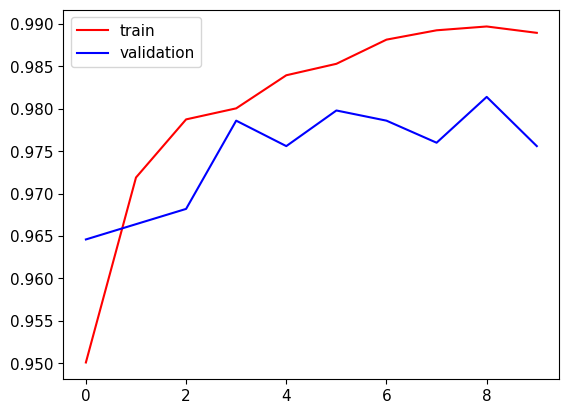

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()


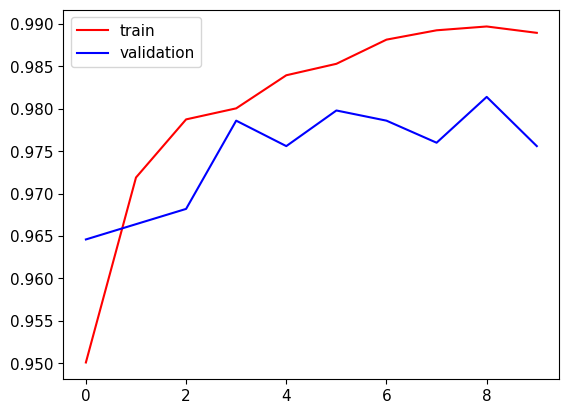

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

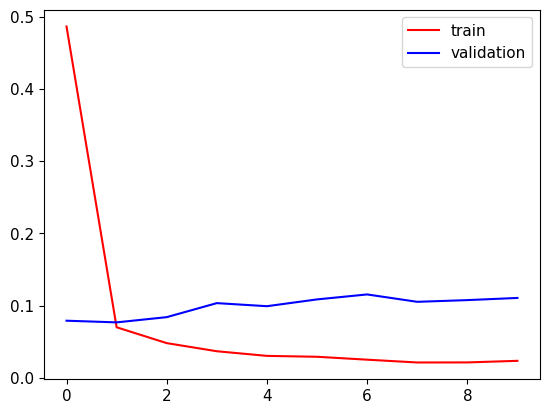

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

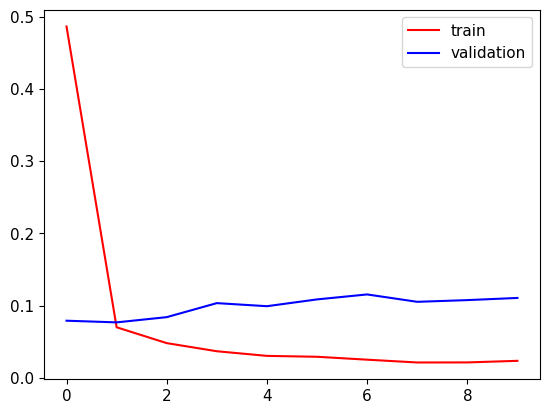

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# ways to reduce overfitting

# Add more data
# Data Augmentation -> next video
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce complexity

In [ ]:
import cv2

In [ ]:
test_img = cv2.imread('/content/cat.jpg')

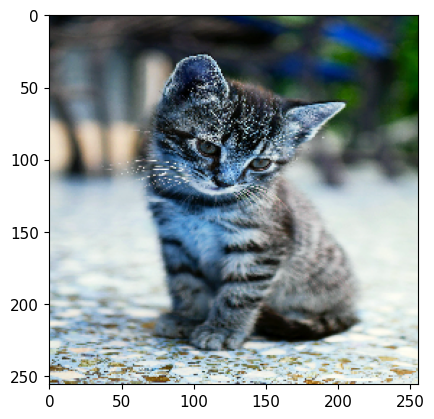

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

(3803, 2853, 3)

In [ ]:
test_img = cv2.resize(test_img,(256,256))

In [ ]:
test_input = test_img.reshape((1,256,256,3))

In [ ]:
prediction = combined_model.predict(test_input)
threshold = 0.5

if prediction > threshold:
    print("Predicted: Dog")
else:
    print("Predicted: Cat")

1/1 [==============================] - 0s 24ms/step
Predicted: Cat
